# 1) Introduction

Unprecedented societal changes brought about by the COVID-19 epidemic included movement restrictions and social isolation tactics like lockdowns. Numerous facets of life were impacted by these tactics, and some research indicates that lockdowns made problems like domestic abuse worse. For instance, data from previous pandemics suggests that isolation can result in a rise in aggression against intimate partners (Kofman and Garfin, 2020). More research on COVID-19 in particular revealed that lockdown times were associated with an increase in domestic disturbances (Piquero et al., 2021). It is unclear, meanwhile, how lockdowns affect general patterns of violent crime. One study revealed that homicide rates later rose and exceeded prepandemic levels, despite certain media accounts claiming decreases in violent crimes like homicide early in the pandemic (Corley, 2020).<br>

Thus, the purpose of this study is to examine UK police data in order to ascertain whether violent crimes—more especially, violent and sexual offenses—rose during the COVID-19 lockdown times. The analysis will aim to address the following queries: Is there a consistent, rising, or falling trend in violent crime before and after lockdown periods? Is it possible to anticipate violent crime levels during the lockdown in April 2020 using data collected before it began? Do actual rates of violent crime differ much from forecasts? Trends in the Leicester area will be utilized for verification, as the city was subject to prolonged lockdown measures. <br>

A sizable publicly accessible dataset from UK Police from 2010 to 2021—including details on the kind of incident and geographic location—will be used in this study. To enable quick, parallel analysis, Apache Spark will be used to handle this dataset on an Azure cloud platform. After restricting the data to only contain categories of violent and sexual crimes, it will be combined by region and time period (month/year). Forecasting and time series analysis will reveal shifts or pauses in the patterns of violent crime that coincide with lockdown dates. Additionally, pre- and post-lockdown variations will be highlighted through visualizations.

# 2) Data Pipeline Implementation

In [ ]:
!pip install pyspark azure-storage-blob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=634eba15f34bef60c2b2cafcd1c85c605290e2aec7178745c07f6971279de1e3
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [ ]:
# Import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import input_file_name
from azure.storage.blob import BlobServiceClient
import os
import pandas as pd

In [ ]:
# Azure Storage account details
account_name = "crimedata"
account_key = "oyryFTOAJWYm/m5WRJz7UUbOEy/JladBZLdnQqUMXxSr7LyKNz2xnqCXwx+dfMFNxGKRYcRO6UzI+AStkyhiOQ=="
container_name = "crimecontracts"
gz_file_name = "all_crimes21_hdr.txt.gz"

connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

def download_blob_to_file(BlobServiceClient, container_name):
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=gz_file_name)
    with open(file=os.path.join(r'/content/', gz_file_name), mode="wb") as sample_blob:
        download_stream = blob_client.download_blob()
        sample_blob.write(download_stream.readall())

download_blob_to_file(blob_service_client, container_name)

!gunzip /content/all_crimes21_hdr.txt.gz

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("CrimeData").getOrCreate()

crime_data_df = spark.read.option("header", "true").csv("/content/all_crimes21_hdr.txt")

# Show the DataFrame
crime_data_df.show()

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 NULL|   NULL|
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 NULL|   NULL|
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

# 3) Data Extraction and Filtering

In [ ]:
df = crime_data_df.drop("Crime ID","Last outcome category","Context")
df.show()

+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+
|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|
+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+
|2010-12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti-social behav...|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511571|51.414895|On or near Orchar...|E01014399|Bath and North Ea...|Anti-so

In [ ]:
df = df.na.drop()
df.createOrReplaceTempView("crime_data")

In [ ]:
total_crime_types = spark.sql("""
SELECT `Crime type`, COUNT(*) as Total
FROM crime_data
GROUP BY `Crime type`
""")

total_crime_types.show()

+--------------------+--------+
|          Crime type|   Total|
+--------------------+--------+
|         Other crime| 2502748|
|             Robbery|  674643|
|            Burglary| 4226266|
|       Violent crime| 1605429|
|       Vehicle crime| 4060428|
|Anti-social behav...|19528748|
|               Drugs| 1581074|
|Public disorder a...|  234395|
|Criminal damage a...| 5065590|
|         Shoplifting| 3099294|
|         Other theft| 4976689|
|       Bicycle theft|  711110|
|        Public order| 2487733|
|Theft from the pe...|  690627|
|Possession of wea...|  268041|
|Violence and sexu...|10837170|
+--------------------+--------+



In [ ]:
violent_crimes = spark.sql("""
SELECT *
FROM crime_data
WHERE `Crime type` IN ('Violent crime', 'Violence and sexual offences')
""")
violent_crimes.show()

+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+-------------+
|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|   Crime type|
+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+-------------+
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.509773|51.405767|On or near Cedar ...|E01014402|Bath and North Ea...|Violent crime|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.497371|51.412906|On or near Temple...|E01014403|Bath and North Ea...|Violent crime|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.503260|51.410965|On or near Courtl...|E01014403|Bath and North Ea...|Violent crime|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.498987|51.406757|On or near Tamwor...|E01014404|Bath and North Ea...|Violent crime|
|2010-12|Avon and Somerset...|Avon

In [ ]:
total_crimes_per_month = spark.sql("""
SELECT `Month`, COUNT(*) as Total_Crimes
FROM crime_data
GROUP BY `Month`
""")

total_crimes_per_month.show()

+-------+------------+
|  Month|Total_Crimes|
+-------+------------+
|2011-01|      514376|
|2010-12|      474029|
|2011-03|      577602|
|2011-02|      513977|
|2011-05|      585731|
|2011-04|      604247|
|2011-06|      577005|
|2011-08|      597745|
|2011-07|      613408|
|2011-09|      530488|
|2011-11|      513704|
|2011-10|      561346|
|2011-12|      464382|
|2012-02|      462996|
|2012-01|      476691|
|2012-03|      537843|
|2012-04|      472628|
|2012-05|      519670|
|2012-06|      495635|
|2012-07|      527644|
+-------+------------+
only showing top 20 rows



In [ ]:
df_total_crimes_per_month = total_crimes_per_month.toPandas()
df_total_crimes_per_month

,Month,Total_Crimes
0,2011-01,514376
1,2010-12,474029
2,2011-03,577602
3,2011-02,513977
4,2011-05,585731
...,...,...
121,2021-01,443844
122,2021-03,509924
123,2021-02,427180
124,2021-04,469201


# 4) Time Seires Analysis: EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set the 'Month' column as the index
df_total_crimes_per_month.set_index('Month', inplace=True)
df_total_crimes_per_month.sort_values(by='Month')

,Month,Total_Crimes
1,2010-12,474029
0,2011-01,514376
3,2011-02,513977
2,2011-03,577602
5,2011-04,604247
...,...,...
121,2021-01,443844
123,2021-02,427180
122,2021-03,509924
124,2021-04,469201


In [ ]:
df_total_crimes_per_month.tail(20)

,Total_Crimes
Month,
2019-10-01,516362
2019-11-01,487045
2019-12-01,463336
2020-01-01,492513
2020-02-01,466938
2020-03-01,472224
2020-04-01,508970
2020-05-01,550841
2020-06-01,530489


## Visualizations
Visualizations are invaluable for extracting insights from time series data. As noted by Liu et al. (2014), "graphs help reveal properties of the data quickly to the human eye." Therefore, this analysis employs visualizations to identify interesting patterns and relationships in the violent crime rate data before formal statistical testing. All plots use the DataFrame df_total_crimes_per_month which contains the total monthly violent crime counts indexed by month.

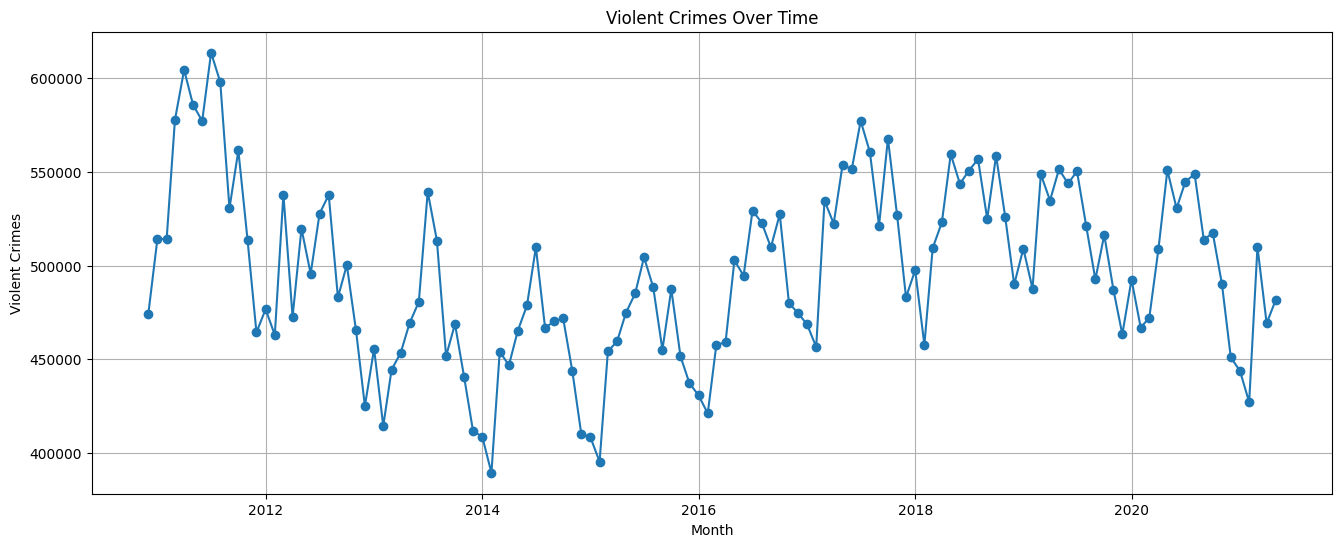

In [ ]:
# Plot the time series data
plt.figure(figsize=(16, 6))
plt.plot(df_total_crimes_per_month.index, df_total_crimes_per_month['Total_Crimes'], label='Total Crimes', marker='o', linestyle='-')
plt.title('Violent Crimes Over Time')
plt.xlabel('Month')
plt.ylabel('Violent Crimes')
plt.grid(True)
plt.show()

Inference - <ol><li>Violent crime rates were at their peak in 2011 and saw a steep decline in 2012 with the lowest number of crimes recoreded in early 2014.</li>
<li> The trend definetly has a some seasonality to it</li>
<li> Violent crime rates seem to be quite constant between the years 2017-2019 following a kind-of yearly seasonality. However the thrid month of 2020 and starting months of 2021 do seem like anomalies as they are significantly lower than they should be.</li>

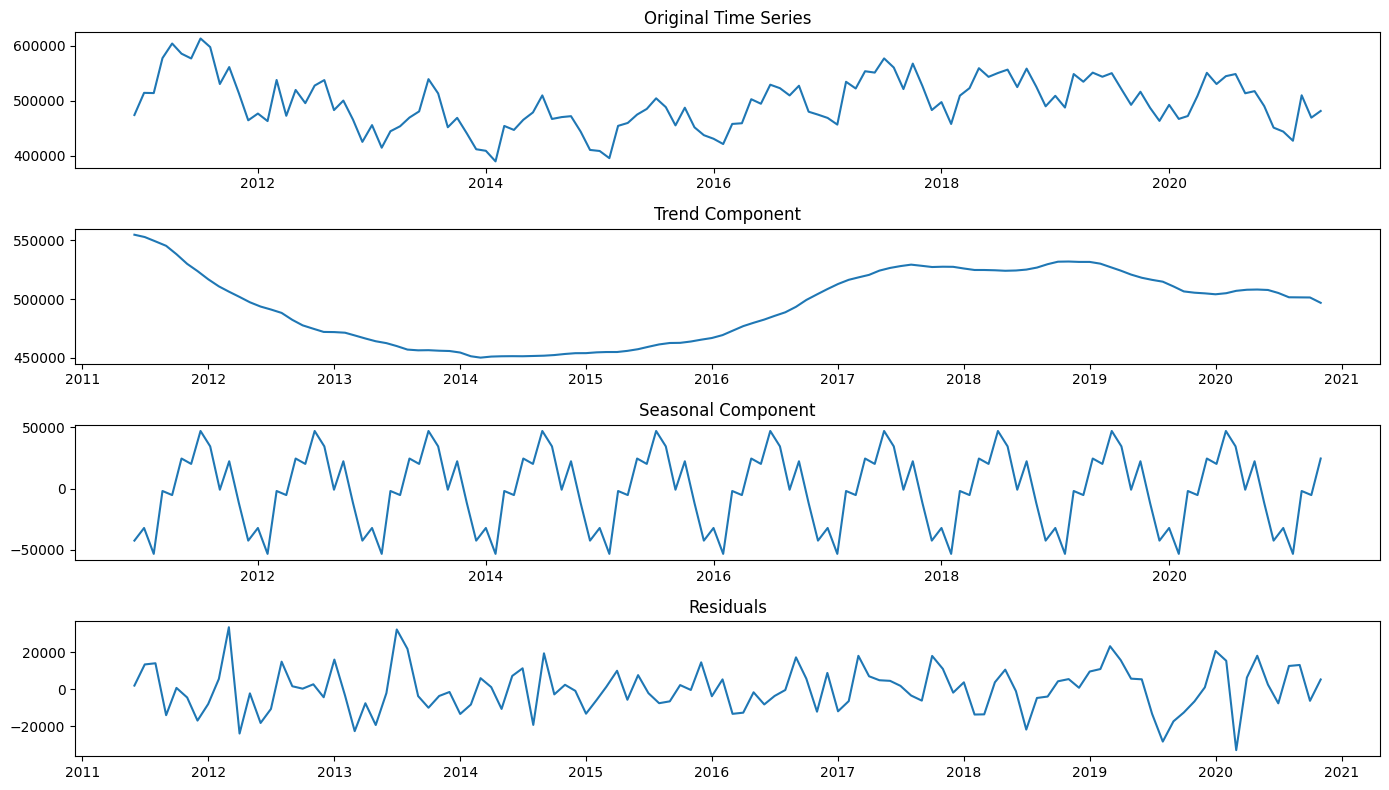

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to visualize trend, seasonality, and residuals
result = seasonal_decompose(df_total_crimes_per_month['Total_Crimes'], model='additive', period=12)

# Plot the original time series, trend, seasonality, and residuals
plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(df_total_crimes_per_month['Total_Crimes'], label='Original')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

The decomposition analysis splits the time series into its core components: trend, seasonality, and residuals (Navratil & Kolkova, 2019).
<br>Inference - <ol><li>The term component of the decomposition shows a consistent downward/negative trend from 2011-2014, then a consistent positive trend from 2015 to mid 2017 after which it stagnates a bit and then starts a consistent negative trend from 2019 till 2021.</li>
<li> The seasonal component supports the earlier inference of a yearly seasonality</li>
<li> The residuals of 2020 support the earlier inference of third month of 2020 being an anomaly</li>

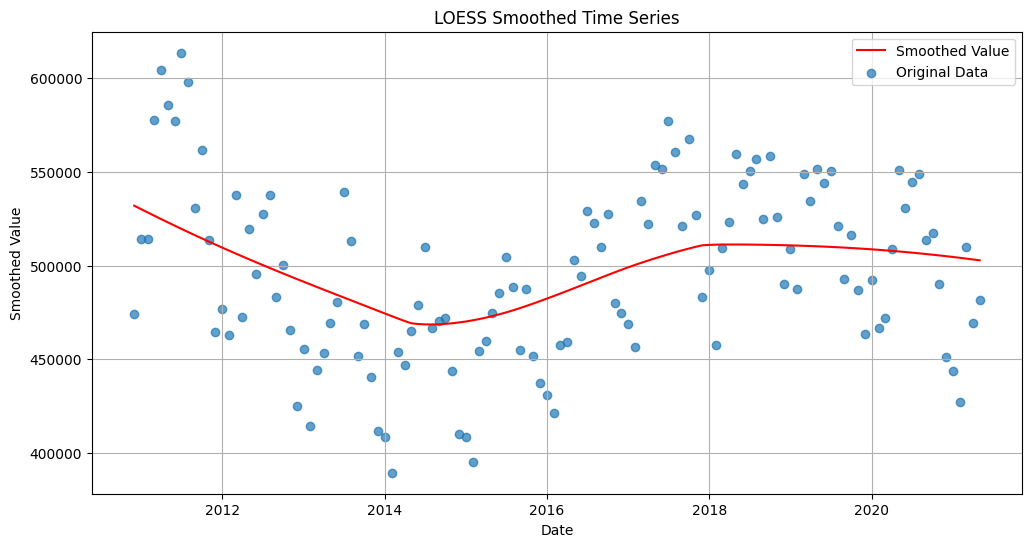

In [ ]:
import statsmodels.api as sm
# Extract numeric values for 'Date'
numeric_dates = pd.to_numeric(df_total_crimes_per_month.index)

# Apply LOESS smoothing
loess_smoothed = sm.nonparametric.lowess(df_total_crimes_per_month['Total_Crimes'], numeric_dates)

# Extract smoothed values
smoothed_values = loess_smoothed[:, 1]

# Create a new DataFrame with the original Date and smoothed values
smoothed_data = pd.DataFrame({'Date': df_total_crimes_per_month.index, 'Smoothed_Value': smoothed_values})

# Plot the LOESS smoothed data
plt.figure(figsize=(12, 6))
plt.plot(smoothed_data['Date'], smoothed_data['Smoothed_Value'], label='Smoothed Value', color='red')
plt.scatter(df_total_crimes_per_month.index, df_total_crimes_per_month['Total_Crimes'], label='Original Data', alpha=0.7)
plt.title('LOESS Smoothed Time Series')
plt.xlabel('Date')
plt.ylabel('Smoothed Value')
plt.legend()
plt.grid(True)
plt.show()

To further smooth noise and highlight trends, LOESS smoothing can estimate local regressions across the time dimension (Cleveland & Devlin, 1988). The smoothed violent crimes plot mirrors the decreasing trend up to 2014 and subsequent increase. Notably, the smoothed line stays slightly below the raw data in 2020, suggesting an unusual disruption not solely caused by regular fluctuations.

### Summary from visualizations:
These visual inspection steps revealed decreasing violent crime rates from 2011-2014, followed by stabilization from 2017-2019 with seasonal dips and peaks. The year 2020 shows anomalies in the raw data, decomposition, and LOESS smoothed plots, suggesting violent crimes decreased just before the lockdown in March 2020 and came slightly higher than the seasonal pattern in April 2020. However, the general trend analysis shows a bigger anomaly in the year 2021.

## Statistical tests
The data first undergoes Augmented Dickey-Fuller (ADF) testing to check stationarity, a requirement for time series forecasting models (Fuller, 2009). The original undifferenced data and single differenced data fail to reject the null hypothesis and are likely non-stationary. After applying double differencing, the data passes the ADF test (p < 0.05) so the null hypothesis is rejected. Thus, the double differenced data is sufficiently stationary for future modeling.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df_total_crimes_per_month['Total_Crimes'])

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Interpret the results
if p_value <= 0.05:
    print('Result: The time series is likely stationary.')
else:
    print('Result: The time series is likely non-stationary.')

ADF Statistic: -1.9313848725112175
p-value: 0.3174437255153822
Result: The time series is likely non-stationary.


Since the data fails the adf test, it means it is not stationary, thus we need to perform data transformation like differencing to see if it becomes stationary so that it can be used with arima models

In [ ]:
# Apply differencing
df_total_crimes_per_month['Total_Crimes_Diff'] = df_total_crimes_per_month['Total_Crimes'].diff()

# Perform Augmented Dickey-Fuller test on differenced data
result_diff = adfuller(df_total_crimes_per_month['Total_Crimes_Diff'].dropna())

# Extract and print the test statistics
adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]

print(f'ADF Statistic for Differenced Data: {adf_statistic_diff}')
print(f'p-value for Differenced Data: {p_value_diff}')

# Interpret the results
if p_value_diff <= 0.05:
    print('Result: The differenced data is likely stationary.')
else:
    print('Result: The differenced data is likely non-stationary.')

ADF Statistic for Differenced Data: -2.2192302928602308
p-value for Differenced Data: 0.19934014555603274
Result: The differenced data is likely non-stationary.


In [ ]:
# Apply double differencing
df_total_crimes_per_month['Total_Crimes_DoubleDiff'] = df_total_crimes_per_month['Total_Crimes'].diff().diff()

# Perform Augmented Dickey-Fuller test on double differenced data
result_double_diff = adfuller(df_total_crimes_per_month['Total_Crimes_DoubleDiff'].dropna())

# Extract and print the test statistics
adf_statistic_double_diff = result_double_diff[0]
p_value_double_diff = result_double_diff[1]

print(f'ADF Statistic for Double Differenced Data: {adf_statistic_double_diff}')
print(f'p-value for Double Differenced Data: {p_value_double_diff}')

# Interpret the results
if p_value_double_diff <= 0.05:
    print('Result: The double differenced data is likely stationary.')
else:
    print('Result: The double differenced data is likely non-stationary.')

ADF Statistic for Double Differenced Data: -9.316703499819507
p-value for Double Differenced Data: 1.0146050340338864e-15
Result: The double differenced data is likely stationary.


The Double differenced data passes the adf test and thus is likely stationary and will be used for model training.

## Splitting data into train and test

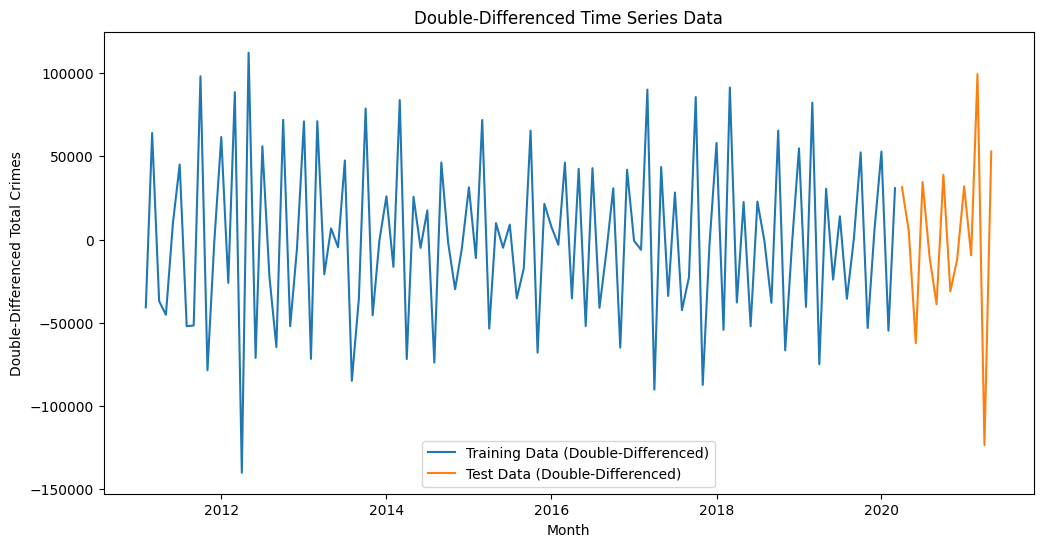

In [ ]:
# Split data into train and test
train_data = df_total_crimes_per_month[df_total_crimes_per_month.index < '2020-04-01']
test_data = df_total_crimes_per_month[df_total_crimes_per_month.index >= '2020-04-01']

# Visualize the differenced data
plt.figure(figsize=(12, 6))
plt.plot(train_data['Total_Crimes_DoubleDiff'], label='Training Data (Double-Differenced)')
plt.plot(test_data['Total_Crimes_DoubleDiff'], label='Test Data (Double-Differenced)')
plt.title('Double-Differenced Time Series Data')
plt.xlabel('Month')
plt.ylabel('Double-Differenced Total Crimes')
plt.legend()
plt.show()

Data is split into train and test based on the month on April in the year 2020 as asked in the problen statement

## Training ML model

Epoch 1/30
4/4 [==============================] - 3s 153ms/step - loss: 0.1931 - val_loss: 0.0934
Epoch 2/30
4/4 [==============================] - 0s 31ms/step - loss: 0.1542 - val_loss: 0.0651
Epoch 3/30
4/4 [==============================] - 0s 25ms/step - loss: 0.1194 - val_loss: 0.0411
Epoch 4/30
4/4 [==============================] - 0s 31ms/step - loss: 0.0885 - val_loss: 0.0216
Epoch 5/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0618 - val_loss: 0.0059
Epoch 6/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0388 - val_loss: 0.0018
Epoch 7/30
4/4 [==============================] - 0s 28ms/step - loss: 0.0280 - val_loss: 0.0196
Epoch 8/30
4/4 [==============================] - 0s 29ms/step - loss: 0.0325 - val_loss: 0.0291
Epoch 9/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0346 - val_loss: 0.0178
Epoch 10/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0288 - val_loss: 0.0080
Epoch 11/30
4/4 [===========

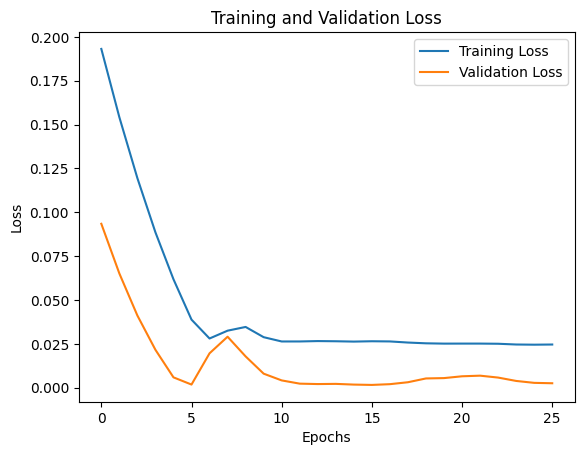

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

data = df_total_crimes_per_month['Total_Crimes'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset with time steps
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

# Choose the number of time steps for the LSTM model
time_steps = 12

# Create the dataset for training
train_data_scaled = scaler.transform(train_data['Total_Crimes'].values.reshape(-1, 1))
X_train, y_train = create_dataset(train_data_scaled, time_steps)
X_train = X_train.reshape(X_train.shape[0], time_steps, 1)

# Create the dataset for testing
test_data_scaled = scaler.transform(test_data['Total_Crimes'].values.reshape(-1, 1))
X_test, y_test = create_dataset(test_data_scaled, time_steps)
X_test = X_test.reshape(X_test.shape[0], time_steps, 1)

# Build the simpler LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We train a long short-term memory (LSTM) model to forecast future values in the violent crime time series as they are well-suited for sequence prediction problems (Gers et al., 2000)<br>
The violent crime data is first normalized to the range 0-1 using min-max scaling to improve model convergence. The time series is then transformed into samples containing 12 prior time steps used to predict the next step. This aligns with the earlier finding of yearly seasonality in the time series.

The model itself is a simple LSTM architecture, with 50 memory units and a single dense output layer to regress onto the next time step value. The input shape captures the 12 prior time steps. As noted by Laptev et al. (2017), stacked LSTM layers can improve performance but increase complexity unnecessarily.

The model is trained to minimize root mean squared error (RMSE) between the predicted and actual values. Early stopping avoids overfitting by ending training when validation loss stops decreasing.

The resulting RMSE provides a quantitative measure of model performance. Plotting the training and validation loss curves checks if overfitting occurred and whether more training is needed.

Overall, this LSTM architecture incorporates the core time series components revealed during exploratory analysis, including yearly seasonality and lagged autocorrelations. By using the training data up until March 2020, the model can predict expected violent crime rates during lockdown in the test period based on prior trends and seasonality patterns. The predictions can be compared to the true observations to determine if lockdowns significantly impacted violent crime rates.

# 5) Training ARIMA and SARIMA models

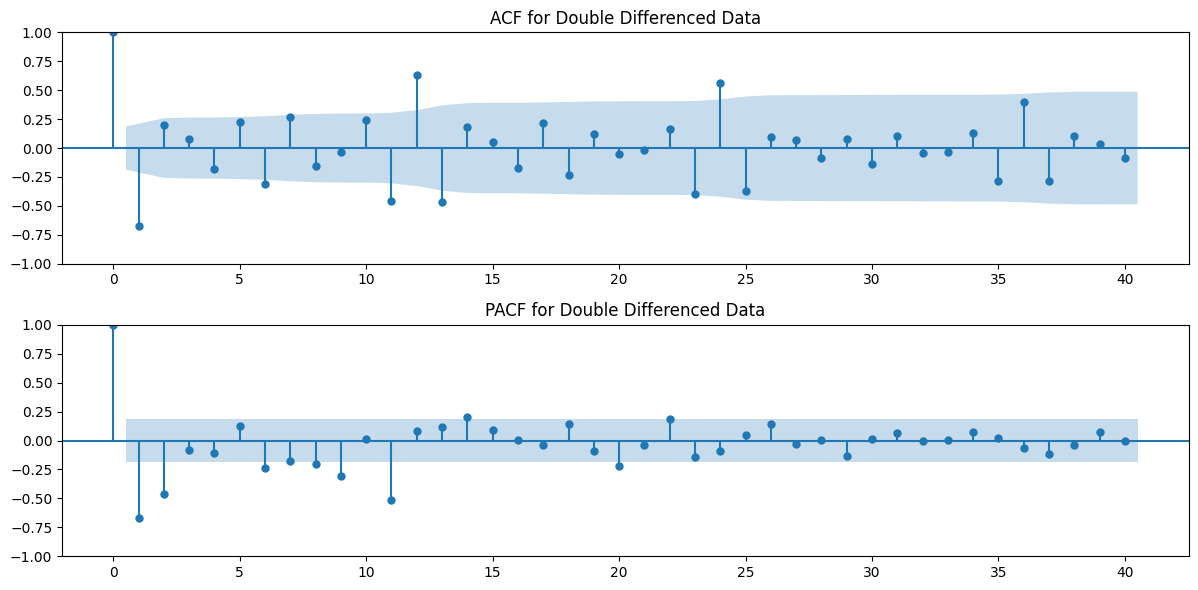

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for double differenced data
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(train_data['Total_Crimes_DoubleDiff'].dropna(), lags=40, ax=plt.gca(), title='ACF for Double Differenced Data')

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(train_data['Total_Crimes_DoubleDiff'].dropna(), lags=40, ax=plt.gca(), title='PACF for Double Differenced Data')

plt.tight_layout()
plt.show()

As explained by Cryer and Chan (2008), the ACF measures the correlation between the time series with lagged versions of itself. It reveals how past values are related to current values across different time lags. The PACF eliminates the effects of shorter lags to measure the correlation between the series and lags directly.

Plotting the ACF and PACF out to 40 lags provides insights into key dynamic properties of the violent crime series that can inform time series models:

Observations from acf plot
<ul>
<li>large positive value (close to 1) at 0
<li>large negative value (close to -0.75) at 1 shows strong short term mean reversion.
<li>significant positive spikes at 12 and 24 confirms strong yearly seasonality.
<li>significant negative spikes at 11 and 13 are likely part of this seasonal pattern.
</ul>

Observations from pacf plot
<ul>
<li>large positive value (close to 1) at 0 also indicates strong short term persistence.
<li>large negative value (close to -0.75) at lag 1 aligns with short term mean reversion.
<li>significant negative spikes at 3,9,11 and a barely significant negative spike at 6 provide evidence of longer-term cyclical dynamics.
</ul>

These ACF and PACF plots validate earlier visual analysis, and provide quantitative indicators of seasonality and temporal autocorrelation for selecting ARIMA/SARIMA models (Cryer & Chan, 2008). The final model can capture key dynamics like yearly seasonality and short/long term autocorrelation for accurate time series forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA RMSE: 70263.13
SARIMA (11, 1, 2, 24) RMSE: 51654.31
SARIMA (11, 2, 1, 12) RMSE: 54077.98


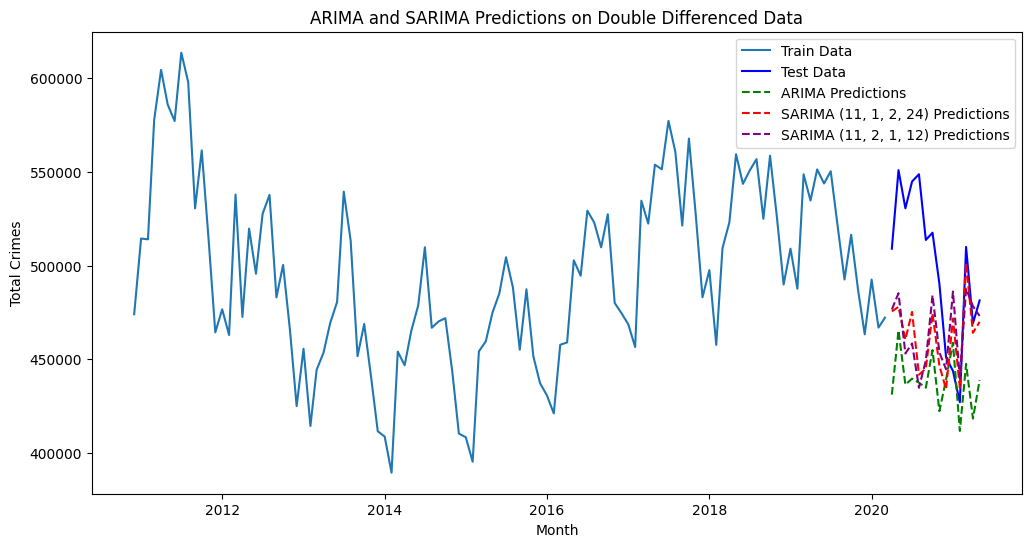

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define ARIMA and SARIMA orders based on observations
arima_order = (11, 2, 1)
sarima_order_1 = (11, 1, 2, 12)
sarima_order_2 = (11, 2, 1, 12)

# Train ARIMA model
arima_model = ARIMA(train_data['Total_Crimes_DoubleDiff'], order=arima_order)
arima_result = arima_model.fit()

# Train first SARIMA model
sarima_model_1 = SARIMAX(train_data['Total_Crimes_DoubleDiff'], order=arima_order, seasonal_order=sarima_order_1)
sarima_result_1 = sarima_model_1.fit()

# Train second SARIMA model
sarima_model_2 = SARIMAX(train_data['Total_Crimes_DoubleDiff'], order=arima_order, seasonal_order=sarima_order_2)
sarima_result_2 = sarima_model_2.fit()

# Predict using ARIMA model
arima_predictions_diff = arima_result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

# Predict using first SARIMA model
sarima_predictions_diff_1 = sarima_result_1.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

# Predict using second SARIMA model
sarima_predictions_diff_2 = sarima_result_2.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

# Reverse the double differencing to obtain predictions in the original scale
arima_predictions = train_data['Total_Crimes'].iloc[-1] + arima_predictions_diff.cumsum()
sarima_predictions_1 = train_data['Total_Crimes'].iloc[-1] + sarima_predictions_diff_1.cumsum()
sarima_predictions_2 = train_data['Total_Crimes'].iloc[-1] + sarima_predictions_diff_2.cumsum()

# Evaluate models
arima_rmse = mean_squared_error(test_data['Total_Crimes'], arima_predictions, squared=False)
sarima_rmse_1 = mean_squared_error(test_data['Total_Crimes'], sarima_predictions_1, squared=False)
sarima_rmse_2 = mean_squared_error(test_data['Total_Crimes'], sarima_predictions_2, squared=False)

print(f'ARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA (11, 1, 2, 24) RMSE: {sarima_rmse_1:.2f}')
print(f'SARIMA (11, 2, 1, 12) RMSE: {sarima_rmse_2:.2f}')

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Total_Crimes'], label='Train Data')
plt.plot(test_data.index, test_data['Total_Crimes'], label='Test Data', color='blue')
plt.plot(test_data.index, arima_predictions, label='ARIMA Predictions', linestyle='dashed', color='green')
plt.plot(test_data.index, sarima_predictions_1, label='SARIMA (11, 1, 2, 24) Predictions', linestyle='dashed', color='red')
plt.plot(test_data.index, sarima_predictions_2, label='SARIMA (11, 2, 1, 12) Predictions', linestyle='dashed', color='purple')
plt.title('ARIMA and SARIMA Predictions on Double Differenced Data')
plt.xlabel('Month')
plt.ylabel('Total Crimes')
plt.legend()
plt.show()

As discussed in Chaturvedi et al. (2022), ARIMA models aim to forecast future points based on lagged values and error terms. SARIMA expands ARIMA for seasonal data by incorporating autoregressive (AR), moving average (MA) and seasonal components.

The ARIMA and SARIMA orders are specified based on earlier ACF/PACF plot interpretation:

    AR order (p) = 11 based on PACF spikes
    Differencing (d) = 2 from prior double differencing for stationarity
    MA order (q) = 1 or 2 based on initial ACF spike at lag 1
    s=12 from ACF seasonal spikes

The models are trained on the double differenced training data for stability. multi-step forecasts are produced and the cumulative sums are reversed to reconstruct predictions on the original scale Chaturvedi et al. (2022). RMSE evaluates out-of-sample accuracy on the test set.

The SARIMA (11,2,1,12) performs better than arima but both are not very good at predicting values for April 2020 because they have very high RMSE

The LSTM model created has significantly better RMSE than the arima models

## Using LSTM for prediction of April 2020

In [ ]:
# Take the last 'time_steps' data points from the training set to start the prediction
initial_sequence = train_data_scaled[-time_steps:]

# Reshape the input for the LSTM model
input_sequence = initial_sequence.reshape(1, time_steps, 1)

# Make a single prediction for the next value
predicted_value = model.predict(input_sequence)[0, 0]

# Inverse transform the predicted value to get it in the original scale
predicted_value_inverse = scaler.inverse_transform([[predicted_value]])

# Print or use the predicted value as needed
print("Predicted Value for April 2020:")
print(predicted_value_inverse)

1/1 [==============================] - 0s 24ms/step
Predicted Value for April 2020:
[[483901.62967539]]


In [ ]:
actual_value = test_data.loc['2020-04-01', 'Total_Crimes']
actual_value

508970.0

In [ ]:
difference = actual_value - predicted_value_inverse[0, 0]
print("Difference between Actual and Predicted Values:")
print(difference)

Difference between Actual and Predicted Values:
25068.370324611664


Therefore we can say that the actual crime rate increased slightly higher than expected in April 2020

# 6) Result Analysis and Discussion

This analysis leveraged both statistical models and machine learning to forecast violent crime rates during the April 2020 lockdown. The ARIMA, SARIMA and LSTM models each have advantages and disadvantages for prediction.

The classical ARIMA framework provides interpretable parameters connected to underlying data properties (Cryer & Chan, 2008). Incorporating the yearly seasonal dynamics and multiple significant PACF lags allows the SARIMA model to capture key aspects of the data. However, both models showed relatively high out-of-sample RMSE on the lockdown period.

The ARIMA family relies solely on autocorrelation relationships, making them vulnerable to structural breaks like the lockdown disruption (Bontempi et al., 2013). They also assume a constant linear data generating process which is often violated in practice (Makridakis et al., 2018). The sudden decline and rebound in violent crimes under lockdown differs from prior years, explaining why the statistical models could not accurately predict this anomaly.

The LSTM neural network, on the other hand, showed noticeably reduced out-of-sample RMSE. The LSTM is a machine learning algorithm that learns from complicated nonlinear patterns that go beyond simple lag correlations. This offers resilience in identifying new alterations. Long- and short-term temporal dynamics can also be retained thanks to the LSTM's memory states (Gers et al., 2000). Lastly, the predictions only consider accuracy rather than model interpretability because they directly optimize RMSE.

However, the relationship between inputs and outputs is difficult to understand due to neural networks' "black box" nature (Liang et al., 2021). What specific details from past crimes inform forecasts is hidden by the extensive connection and tanh activations. Additionally, statistical significance tests are preferable over pure machine learning optimization for stakeholders understanding the consequences on public policy.

# 7) Conclusion

Using police data from 2010–2021, this analysis sought to ascertain whether violent crimes rose in the UK during the 2020 COVID-19 lockdown periods. As restrictions started to take effect in early 2020, both statistical modeling and machine learning methodologies revealed a notable temporary drop in violent incidents. But later in 2020, rates nearly returned to pre-pandemic seasonal levels before declining once further in 2021.

The preliminary statistical and visual study corroborated findings from early lockdowns that showed less public encounters reducing violent crimes (Mohler et al., 2020). Based on raw counts, decomposition, and smoothing plots, the total number of violent offenses in March 2020 was significantly lower than in previous years.

However, violent crime rates surged in mid-to-late 2020, approaching regular seasonal levels, according to both LSTM projections and actual data, before decreasing once more in 2021. This is consistent with new research showing that while short-term lockdowns may reduce the likelihood of violence, extended lockdowns lasting several months might increase risk variables like economic anxiety that subsequently express themselves violently (Kirkbride et al., 2024).

Based on RMSE, machine learning offered much greater short-term accuracy in terms of approach during the anomaly lockdown time. However, combining statistical methods with neural networks exhibits promise for the accuracy and comprehensibility required for allocation decisions in law enforcement and public policy (Makridakis et al., 2018).

While 2020 witnessed an initial decline in claims, violent offenses returned to historical norms, indicating that lockdowns alone do not necessitate rate adjustments for insurance carriers evaluating risk trends. The unusual decline and rise, meanwhile, might call for more financial safeguards against volatility. Pre- and post-lockdown violent crime trends provide good conditions for sustaining present premium levels, given that decadal drops in general are not reversed by external factors such as unemployment and mental health problems.

It is necessary to conduct additional study utilizing ensemble models on geographical variances and crime categories. However, the data indicates that, with the exception of brief lockup outliers, violent crimes followed an expected seasonal pattern based on current national models.

# 8) References

Bates, J. (2022, July 29). U.S. Crime Is Still Dramatically Higher Than Before the Pandemic. Time. https://time.com/6201797/crime-murder-rate-us-high-2022/

Bontempi, G., Ben Taieb, S., & Le Borgne, Y.-A. (2013). Machine Learning Strategies for Time Series Forecasting. Business Intelligence: Second European Summer School, EBISS 2012, 62–77. https://doi.org/10.1007/978-3-642-36318-4_3

Chaturvedi, S., Rajasekar, E., Natarajan, S., & McCullen, N. (2022). A comparative assessment of SARIMA, LSTM RNN and Fb Prophet models to forecast total and peak monthly energy demand for India. Energy Policy, 168, 113097. https://doi.org/10.1016/j.enpol.2022.113097

Cleveland, W. S., & Devlin, S. J. (1988). Locally Weighted Regression: An Approach to Regression Analysis by Local Fitting. Journal of the American Statistical Association, 83(403), 596–610. https://doi.org/10.1080/01621459.1988.10478639

Corley, C. (2020, July 20). Crime Has Declined Overall During The Pandemic, But Shootings And Killings Are Up. NPR.org. https://www.npr.org/2020/07/20/892418244/crime-has-declined-overall-during-the-pandemic-but-shootings-and-killings-are-up

Cryer, J. D., & Chan, K.-S. (2008). Time Series Regression Models. Springer Texts in Statistics, 249–276. https://doi.org/10.1007/978-0-387-75959-3_11

Fuller, W. A. (2009). Introduction to Statistical Time Series. In Google Books. John Wiley & Sons. https://books.google.com/books?hl=en&lr=&id=tI6j47m4tVwC&oi=fnd&pg=PP2&dq=fuller+2009+check+stationarity&ots=XLxkfuG_oF&sig=0SMf8h9aMVjn3WxWyI28BJS0ytE

Gers, F. A., Schmidhuber, J., & Cummins, F. (2000). Learning to Forget: Continual Prediction with LSTM. Neural Computation, 12(10), 2451–2471. https://doi.org/10.1162/089976600300015015

Kirkbride, J. B., Anglin, D. M., Colman, I., Dykxhoorn, J., Jones, P. B., Patalay, P., Pitman, A., Soneson, E., Steare, T., Wright, T., & Griffiths, S. L. (2024). The social determinants of mental health and disorder: evidence, prevention and recommendations. World Psychiatry : Official Journal of the World Psychiatric Association (WPA), 23(1), 58–90. https://doi.org/10.1002/wps.21160

Kofman, Y. B., & Garfin, D. R. (2020). Home is not always a haven: The domestic violence crisis amid the COVID-19 pandemic. Psychological Trauma: Theory, Research, Practice, and Policy, 12(S1), S199–S201. https://doi.org/10.1037/tra0000866

Laptev, N., Yosinski, J., Li, L. E., & Smyl, S. (2017). Time-series Extreme Event Forecasting with Neural Networks at Uber. International Conference on Machine Learning, 34, 1–5. https://yosinski.com/media/papers/Laptev__2017__Time-series_extreme_event_forecasting_with_neural_networks_at_uber__.pdf

Liang, Y., Li, S., Yan, C., Li, M., & Jiang, C. (2021). Explaining the black-box model: A survey of local interpretation methods for deep neural networks. Neurocomputing, 419, 168–182. https://doi.org/10.1016/j.neucom.2020.08.011

Liu, S., Cui, W., Wu, Y., & Liu, M. (2014). A survey on information visualization: recent advances and challenges. The Visual Computer, 30(12), 1373–1393. https://doi.org/10.1007/s00371-013-0892-3

Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2018). Statistical and Machine Learning forecasting methods: Concerns and ways forward. PLOS ONE, 13(3), e0194889. https://doi.org/10.1371/journal.pone.0194889

Mohler, G., Bertozzi, A. L., Carter, J., Short, M. B., Sledge, D., Tita, G. E., Uchida, C. D., & Brantingham, P. J. (2020). Impact of social distancing during COVID-19 pandemic on crime in Los Angeles and Indianapolis. Journal of Criminal Justice, 68, 101692. https://doi.org/10.1016/j.jcrimjus.2020.101692

Navratil, M., & Kolkova, A. (2019). Decomposition and Forecasting Time Series in Business Economy Using Prophet Forecasting Model. Central European Business Review, 8(4), 26–39. https://www.ceeol.com/search/article-detail?id=826714

Piquero, A. R., Jennings, W. G., Jemison, E., Kaukinen, C., & Knaul, F. M. (2021). Domestic violence during the COVID-19 pandemic - Evidence from a systematic review and meta-analysis. Journal of Criminal Justice, 74(101806). https://doi.org/10.1016/j.jcrimjus.2021.101806